after initial bring good features in

logistic regression random forest (single decision tree) 
(no SVM due to many rows dataset, KNN did example in class and have some experience, naive bayes)

ROC curves precision, recall, (spec), f1 score type 1 error and type 2 error

cost benefit analysis?

interpret log odds with coefficient. One increase in coefficient is equivalent to what increase/decrease in log odds.

make y include deaths and injuries
make plot of ROC and calculate precision vs recall

In [7]:
from __future__ import print_function, division
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [8]:
import pickle
with open("combined_dummified_df.pkl", 'rb') as picklefile: 
    combined_df = pickle.load(picklefile)

In [9]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504723 entries, 0 to 504722
Data columns (total 90 columns):
Temperature                                 504723 non-null float64
BEGIN_YEARMONTH                             504723 non-null object
Precipitation                               504723 non-null float64
EVENT_ID                                    504723 non-null int64
INJURIES_DIRECT                             504723 non-null float64
INJURIES_INDIRECT                           504723 non-null float64
DEATHS_DIRECT                               504723 non-null float64
DEATHS_INDIRECT                             504723 non-null float64
MAGNITUDE                                   504723 non-null float64
BEGIN_LAT                                   504723 non-null float64
BEGIN_LON                                   504723 non-null float64
DAMAGE_PROPERTY                             504723 non-null float64
STATE[T.ALASKA]                             504723 non-null float64
STATE[T.

In [10]:
# make datetime object into date
combined_df['Year'] = combined_df.BEGIN_YEARMONTH.apply(lambda x: x.year - 1955)
combined_df['Month'] = combined_df.BEGIN_YEARMONTH.apply(lambda x: x.month)
combined_df['DAMAGE_SCORE'] = combined_df['DAMAGE_PROPERTY'] + (8e6)*combined_df['DEATHS_DIRECT']

In [11]:
front = combined_df[['DAMAGE_SCORE', 'Year', 'Month']]
combined_df = combined_df.drop(columns = ['DAMAGE_SCORE', 'Year', 'Month'])
combined_df = combined_df.drop(columns = ['BEGIN_YEARMONTH', 'EVENT_ID'])
combined_df = pd.concat([front, combined_df], axis = 1)
combined_df = combined_df.drop(columns = ['INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT'])
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504723 entries, 0 to 504722
Data columns (total 87 columns):
DAMAGE_SCORE                                504723 non-null float64
Year                                        504723 non-null int64
Month                                       504723 non-null int64
Temperature                                 504723 non-null float64
Precipitation                               504723 non-null float64
MAGNITUDE                                   504723 non-null float64
BEGIN_LAT                                   504723 non-null float64
BEGIN_LON                                   504723 non-null float64
DAMAGE_PROPERTY                             504723 non-null float64
STATE[T.ALASKA]                             504723 non-null float64
STATE[T.AMERICAN SAMOA]                     504723 non-null float64
STATE[T.ARIZONA]                            504723 non-null float64
STATE[T.ARKANSAS]                           504723 non-null float64
STATE[T.A

In [12]:
# 9 million human life
def categorical_labeling(damage):
    if damage > 100000:
        return 'Major'
    elif damage > 1000:
        return 'Minor'
    else:
        return 'Negligible'

In [13]:
def binary_labeling(damage):
    if damage > 100000:
        return 1
    else:
        return 0

In [14]:
# make labels
category_list = []
combined_df['Category'] = combined_df.DAMAGE_SCORE.apply(categorical_labeling)
binary_list = []
combined_df['Binary'] = combined_df.DAMAGE_SCORE.apply(binary_labeling)


In [15]:
# set up data with stratified sampling
X = combined_df.drop(columns = ['Category','Binary', 'DAMAGE_SCORE', 'DAMAGE_PROPERTY'])
y = combined_df.Binary
y_cat = combined_df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
X_cattrain, X_cattest, y_cattrain, y_cattest = train_test_split(X, y_cat, test_size=0.2, stratify = y_cat)

In [16]:
# X.describe()

,Year,Month,Temperature,Precipitation,MAGNITUDE,BEGIN_LAT,BEGIN_LON,STATE[T.ALASKA],STATE[T.AMERICAN SAMOA],STATE[T.ARIZONA],STATE[T.ARKANSAS],STATE[T.ATLANTIC NORTH],STATE[T.ATLANTIC SOUTH],STATE[T.CALIFORNIA],STATE[T.COLORADO],STATE[T.CONNECTICUT],STATE[T.DELAWARE],STATE[T.DISTRICT OF COLUMBIA],STATE[T.E PACIFIC],STATE[T.FLORIDA],STATE[T.GEORGIA],STATE[T.GUAM],STATE[T.GULF OF ALASKA],STATE[T.GULF OF MEXICO],STATE[T.HAWAII],STATE[T.HAWAII WATERS],STATE[T.IDAHO],STATE[T.ILLINOIS],STATE[T.INDIANA],STATE[T.IOWA],STATE[T.KANSAS],STATE[T.KENTUCKY],STATE[T.LAKE ERIE],STATE[T.LAKE HURON],STATE[T.LAKE MICHIGAN],STATE[T.LAKE ONTARIO],STATE[T.LAKE ST CLAIR],STATE[T.LAKE SUPERIOR],STATE[T.LOUISIANA],STATE[T.MAINE],STATE[T.MARYLAND],STATE[T.MASSACHUSETTS],STATE[T.MICHIGAN],STATE[T.MINNESOTA],STATE[T.MISSISSIPPI],STATE[T.MISSOURI],STATE[T.MONTANA],STATE[T.NEBRASKA],STATE[T.NEVADA],STATE[T.NEW HAMPSHIRE],STATE[T.NEW JERSEY],STATE[T.NEW MEXICO],STATE[T.NEW YORK],STATE[T.NORTH CAROLINA],STATE[T.NORTH DAKOTA],STATE[T.OHIO],STATE[T.OKLAHOMA],STATE[T.OREGON],STATE[T.PENNSYLVANIA],STATE[T.PUERTO RICO],STATE[T.RHODE ISLAND],STATE[T.SOUTH CAROLINA],STATE[T.SOUTH DAKOTA],STATE[T.ST LAWRENCE R],STATE[T.TENNESSEE],STATE[T.TEXAS],STATE[T.UTAH],STATE[T.VERMONT],STATE[T.VIRGIN ISLANDS],STATE[T.VIRGINIA],STATE[T.WASHINGTON],STATE[T.WEST VIRGINIA],STATE[T.WISCONSIN],STATE[T.WYOMING],EVENT_TYPE[T.Hurricane],EVENT_TYPE[T.Marine High Wind],EVENT_TYPE[T.Marine Hurricane/Typhoon],EVENT_TYPE[T.Marine Strong Wind],EVENT_TYPE[T.Marine Thunderstorm Wind],EVENT_TYPE[T.Marine Tropical Depression],EVENT_TYPE[T.Marine Tropical Storm],EVENT_TYPE[T.Strong Wind],EVENT_TYPE[T.Thunderstorm Wind],EVENT_TYPE[T.Tropical Depression],EVENT_TYPE[T.Tropical Storm]
count,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.00000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.00000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000,504723.0,504723.000000,504723.000000,504723.000000,504723.000000,504723.000000
mean,46.235947,6.360007,12.598918,61.354923,43.786743,37.732732,-90.608638,0.006259,0.000107,0.006901,0.028138,0.011646,0.00511,0.009910,0.010124,0.004034,0.002700,0.000458,0.000222,0.023300,0.040858,0.000254,0.000063,0.013253,0.001020,0.000018,0.003901,0.033920,0.025727,0.030870,0.039814,0.030127,0.003988,0.001363,0.003336,0.000226,0.000592,0.000870,0.022400,0.007370,0.011723,0.009736,0.023145,0.021572,0.030377,0.030728,0.016183,0.022204,0.004076,0.004282,0.013550,0.006229,0.028665,0.034411,0.011836,0.035190,0.035794,0.005672,0.032895,0.000789,0.001381,0.025257,0.020257,0.000014,0.03053,0.061731,0.003598,0.004569,0.000135,0.027855,0.004107,0.011369,0.023017,0.010846,0.005573,0.000640,0.000026,0.000244,0.039766,0.0,0.000032,0.033371,0.799001,0.000628,0.008024
std,11.744234,2.479823,8.300689,10.719308,20.900061,4.137658,34.937710,0.078865,0.010343,0.082784,0.165368,0.107286,0.07130,0.099056,0.100109,0.063385,0.051896,0.021389,0.014895,0.150854,0.197961,0.015923,0.007962,0.114356,0.031927,0.004223,0.062337,0.181022,0.158320,0.172967,0.195522,0.170938,0.063

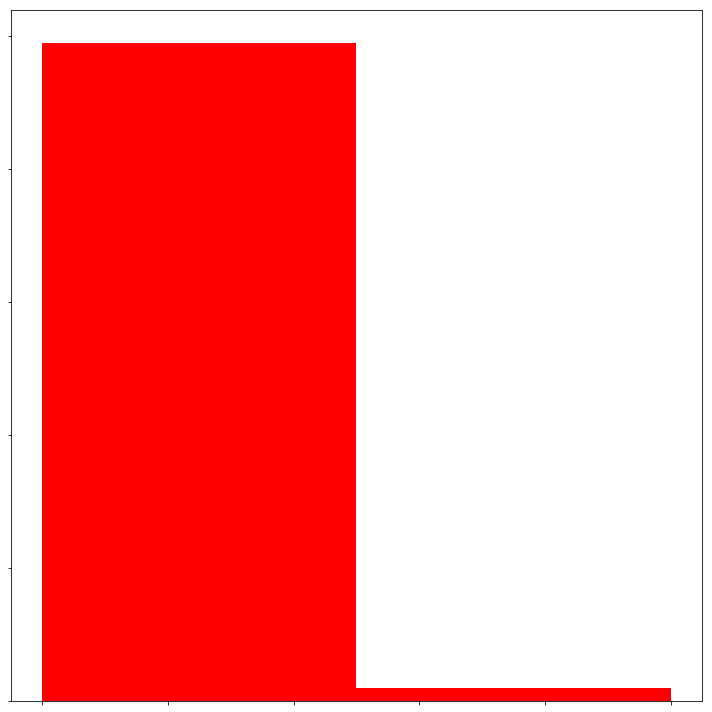

In [17]:
fig, ax = plt.subplots(figsize=[10,10])
# ax.set_title('Class Imbalance', fontsize = 30)
# ax.set_xlabel('Disaster or Not')
# ax.set_ylabel('Examples')
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(['']*len(labels))
labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(['']*len(labels))
y_plot = y_test.apply(lambda x: str(int(x)))
# ax.set_xticks([0,1])
# sns.distplot(y_test, kde = False);
bins = np.array([0, 0.5, 1.0]) # just two bins
plt.hist(y_test, bins, color = 'red')
plt.tight_layout();

In [18]:
# set up data with stratified sampling
X = combined_df.drop(columns = ['Category','Binary', 'DAMAGE_SCORE', 'DAMAGE_PROPERTY'])
# X = combined_df[['Year','Month','Temperature','Precipitation','MAGNITUDE', 'BEGIN_LAT', 'BEGIN_LON']]
y = combined_df.Binary
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403778 entries, 155148 to 153364
Data columns (total 85 columns):
Year                                        403778 non-null int64
Month                                       403778 non-null int64
Temperature                                 403778 non-null float64
Precipitation                               403778 non-null float64
MAGNITUDE                                   403778 non-null float64
BEGIN_LAT                                   403778 non-null float64
BEGIN_LON                                   403778 non-null float64
STATE[T.ALASKA]                             403778 non-null float64
STATE[T.AMERICAN SAMOA]                     403778 non-null float64
STATE[T.ARIZONA]                            403778 non-null float64
STATE[T.ARKANSAS]                           403778 non-null float64
STATE[T.ATLANTIC NORTH]                     403778 non-null float64
STATE[T.ATLANTIC SOUTH]                     403778 non-null float64
STAT

In [19]:
# # test for training one lr model
# %%time
# lr = LogisticRegression(solver = 'liblinear')
# lr.fit(X_train, y_train)
# # lr.summary

In [21]:
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
    import itertools
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

In [22]:
def model_stats_binary(y_test, y_pred):
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
    conf = confusion_matrix(y_test, y_pred, labels = [1,0])
    sum_conf = np.sum(conf)
    percent_conf = conf/sum_conf
#     print(conf)
#     plot_confusion_matrix(conf)
    precision_major = conf[0,0]/(conf[0,0] + conf[1,0])
    precision_minor = conf[1,1]/(conf[0,1] + conf[1,1])
    recall_major = conf[0,0]/(conf[0,0] + conf[0,1])
    recall_minor = conf[1,1]/(conf[1,0] + conf[1,1])
    f1_score = 2*(precision_major*recall_major)/(precision_major+recall_major)
    print(f'Precision is {precision_major}.')
    print(f'Recall/Sensitivity/TPR is {recall_major}.')
    print(f'Precision of non-major disaster is {precision_minor}.')
    print(f'Specificity/(1-FPR) is {recall_minor}.')
    print(f'F1 score is {f1_score}.')
    return
#     return precision_major, precision_minor, recall_major, recall_minor

In [100]:
#initial look at results
# print(random.best_estimator_)
# print(random.best_params_)
# print(random.best_score_)
# y_pred = random.predict(X_test)
# model_stats_binary(y_test, y_pred)
# print(f'F10 score is {fbeta_score(y_test, y_pred, 10)}.')

LogisticRegression(C=0.004417344703140069, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
{'penalty': 'l1', 'C': 0.004417344703140069}
0.0002475259785190264
Precision for major disaster is 0.0.
Recall for major disaster is 0.0.
Precision for non-major disaster is 0.9800182282895128.
Recall for non-major disaster is 0.9999696749150898.
F1 score is nan.
F10 score is 0.0.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [23]:
# # collecting all models tested
# from sklearn.externals import joblib
# random_models = []
# # random = joblib.load('logisticrandomsearch.joblib')
# lr_model_list = ['/Users/dynogravelso/Documents/GitHub/mcnulty/logisticrandomsearch_f1.joblib',
# '/Users/dynogravelso/Documents/GitHub/mcnulty/logisticrandomsearch_f1balanced.joblib',
# '/Users/dynogravelso/Documents/GitHub/mcnulty/logisticrandomsearch_f2.joblib',
# '/Users/dynogravelso/Documents/GitHub/mcnulty/logisticrandomsearch_precisionbalanced.joblib',
# '/Users/dynogravelso/Documents/GitHub/mcnulty/logisticrandomsearch_recall.joblib',
# '/Users/dynogravelso/Documents/GitHub/mcnulty/logisticrandomsearch_recallbalanced.joblib']
# random_models = [joblib.load(model) for model in lr_model_list]
# joblib.dump(random_models, 'logisticallmodels.joblib')

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomizedSearchCV from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use a

['logisticallmodels.joblib']

In [25]:
# now printing out results for all tested models
from sklearn.metrics import fbeta_score, make_scorer, auc, roc_curve
fbeta_scorer = make_scorer(fbeta_score, beta=2)

for i, model in enumerate(random_models):
    print(lr_model_list[i])
    print(model.best_estimator_)
    print(model.best_params_)
    print(model.best_score_)
#     print(model.best_estimator_.coef_)
    y_pred = model.predict(X_test)
    model_stats_binary(y_test, y_pred)
    print(f'F10 score is {fbeta_score(y_test, y_pred, 10)}.')
    print()


/Users/dynogravelso/Documents/GitHub/mcnulty/logisticrandomsearch_f1.joblib
LogisticRegression(C=3.046989570903508, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=True, warm_start=False)
{'penalty': 'l1', 'C': 3.046989570903508}
0.19145225797354087
Precision is 0.7789855072463768.
Recall/Sensitivity/TPR is 0.1065939514129896.
Precision of non-major disaster is 0.9820997526547398.
Specificity/(1-FPR) is 0.9993833899401585.
F1 score is 0.18752725686873092.
F10 score is 0.10751277379490633.

/Users/dynogravelso/Documents/GitHub/mcnulty/logisticrandomsearch_f1balanced.joblib
LogisticRegression(C=0.014497406703726316, class_weight='balanced',
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
          random_state=None, solver='liblinear', 

In [26]:
# attempt at manual weeding out features, regularization takes care of this more easily
def weed_features(model):
    coefs = model.best_estimator_.coef_[0]
    feat_sel = []
    for coef in coefs:
#         print(coef)
        if abs(coef) <= 0.001:
            feat_sel.append(0)
        else:
            feat_sel.append(1)
    return feat_sel            

In [27]:
# metrics.accuracy_score(y_test, y_pred)
y_base = np.array([0 for i in range(0, 100945)])
# model_stats_binary(y_test,y_pred)
model_stats_binary(y_test, y_base)

Precision is nan.
Recall/Sensitivity/TPR is 0.0.
Precision of non-major disaster is 0.9800188221308633.
Specificity/(1-FPR) is 1.0.
F1 score is nan.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [28]:
# a look at the coefficients
coefs = list(random_models[2].best_estimator_.coef_[0])
features = list(X.columns)
list(X.columns)
coefs
coef_analysis = zip(features, coefs)
coef_analysis = list(coef_analysis)
cont_coef_analysis = coef_analysis[0:7]
print(cont_coef_analysis)
significant_dummy_coefs = [coef for coef in coef_analysis if abs(coef[1]) > 1]
significant_dummy_coefs


[('Year', 0.018354809678055414), ('Month', -0.012647163739141811), ('Temperature', 0.0014320771096627547), ('Precipitation', -0.0033769830507948363), ('MAGNITUDE', 0.045918915197869996), ('BEGIN_LAT', 0.007810198872029277), ('BEGIN_LON', 6.472889884728657e-05)]


[('STATE[T.ALASKA]', -1.7411274718456313),
 ('STATE[T.AMERICAN SAMOA]', -2.4863364907021355),
 ('STATE[T.COLORADO]', -1.3099166697248303),
 ('STATE[T.HAWAII]', -1.2906586151423378),
 ('STATE[T.HAWAII WATERS]', 1.8925012569683404),
 ('STATE[T.LAKE ERIE]', -1.7466963880637862),
 ('STATE[T.LAKE HURON]', -1.062915627654105),
 ('STATE[T.LOUISIANA]', 1.1028166272549327),
 ('STATE[T.MAINE]', -1.8784003194843757),
 ('STATE[T.MONTANA]', -1.5240485383147715),
 ('STATE[T.RHODE ISLAND]', -1.0491920150510259),
 ('STATE[T.SOUTH DAKOTA]', -1.602417866958561),
 ('STATE[T.VIRGIN ISLANDS]', -1.3006482539958604),
 ('STATE[T.WYOMING]', -2.8300332147755998),
 ('EVENT_TYPE[T.Hurricane]', 2.3805994962741353),
 ('EVENT_TYPE[T.Marine Strong Wind]', 3.14725818728067),
 ('EVENT_TYPE[T.Marine Thunderstorm Wind]', -2.0801560405292245),
 ('EVENT_TYPE[T.Tropical Depression]', 4.100858301725617),
 ('EVENT_TYPE[T.Tropical Storm]', 1.601708100057276)]

Area under curve: 0.7919422385463493


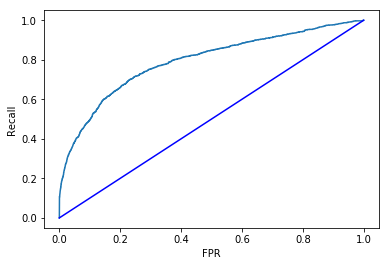

In [29]:
# plot roc curve
from sklearn.metrics import roc_curve, auc

#f2 score rf
y_base = np.zeros(100945)
fig, ax = plt.subplots()
for i, model in enumerate(random_models):
    if i == 2:
        random = model
        y_score=random.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr)
        print(f'Area under curve: {roc_auc}')

# Plotting Baseline..
plt.plot([0,1],[0,1], color = 'blue')

ax.set_xlabel('FPR')
ax.set_ylabel('Recall');

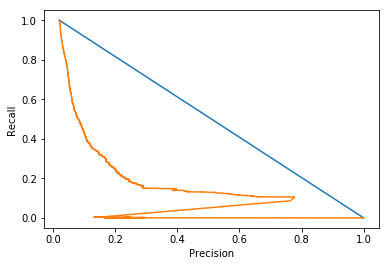

In [35]:
# I suspect the weird dip in precision in the end to be caused when there no storms when very few storms are predicted to be a disaster 

from sklearn.metrics import precision_recall_curve

#f1 score lr
random = random_models[3]
y_base = np.zeros(100945)

y_score=random.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# prc_auc = auc(fpr, tpr)
precision_base, recall_base, _ = precision_recall_curve(y_test, y_base)

# Plotting our Baseline..
fig, ax = plt.subplots()
plt.plot(precision_base, recall_base) #baseline model
plt.plot(precision, recall)
# sns.lineplot(fpr_base, tpr_base)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall');
# print(f'Area under curve: {prc_auc}')

In [178]:
# manual precision recall check
# threshold_wanted = 0.38
for i, threshold in enumerate(thresholds):
    if precision[i] > 0.1 and recall[i] > 0.35:
#         print(f'Threshold is {threshold}.')
#         print(f'Precision is {precision[i]}.')
#         print(f'Recall is {recall[i]}.')
#         print(i, precision[i], recall[i], threshold)
        pass
i = 88600
print(precision[i])
print(recall[i])
print(thresholds[i])

0.34375
0.17997025285076848
0.1069065702734326
